In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from torchvision.transforms.functional import to_tensor, to_pil_image
import matplotlib.pyplot as plt

import torch.nn.functional as F


In [24]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out
    
def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
        
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))



Files already downloaded and verified


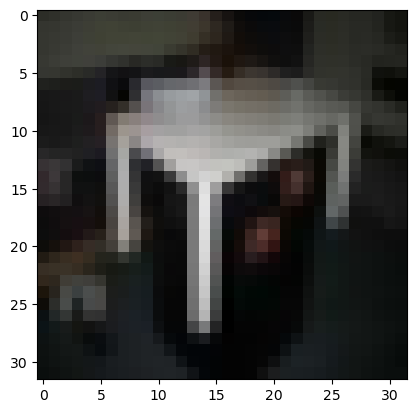

In [25]:
from torchvision import models, datasets, transforms

img_index = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.ToTensor()
tt = transforms.ToPILImage()
gt_data = tp(dst[img_index][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label)
plt.imshow(tt(gt_data[0].cpu()))

In [26]:
net = LeNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot
pred = net(gt_data)
y = criterion(pred, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

In [48]:
'''dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
#dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
dummy_label = gt_onehot_label

optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        dummy_pred = net(dummy_data) 
        #dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        #dummy_loss = criterion(dummy_pred, dummy_onehot_label)
        #dummy_loss = criterion(dummy_pred, gt_onehot_label)
        dummy_loss = criterion(dummy_pred, dummy_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))'''
        
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
#dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)
dummy_label = gt_onehot_label

optimizer = torch.optim.SGD([dummy_data], lr=0.01)

history = []
for iters in range(300000):
    optimizer.zero_grad()
    dummy_pred = net(dummy_data)
    dummy_loss = criterion(dummy_pred, dummy_label)
    dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
    
    grad_diff = 0
    for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
        grad_diff += ((gx - gy) ** 2).sum()
        
    grad_diff.backward()
    optimizer.step()
    
    if iters % 10 == 0:
        current_loss = grad_diff
        print(iters, "%.4f" % current_loss.item())
    
    if iters % 10000 == 0: 
        history.append(tt(dummy_data[0].cpu()))

0 131.7882
10 85.5180
20 72.8496
30 66.5757
40 62.0106
50 58.3548
60 55.2726
70 52.5991
80 50.2582
90 48.1779
100 46.3209
110 44.6702
120 43.1758
130 41.8289
140 40.5969
150 39.4664
160 38.4313
170 37.4681
180 36.5743
190 35.7397
200 34.9460
210 34.2001
220 33.4945
230 32.8265
240 32.1899
250 31.5932
260 31.0243
270 30.4891
280 29.9876
290 29.5107
300 29.0576
310 28.6300
320 28.2218
330 27.8296
340 27.4608
350 27.1034
360 26.7602
370 26.4282
380 26.1107
390 25.8008
400 25.5015
410 25.2112
420 24.9285
430 24.6524
440 24.3835
450 24.1209
460 23.8669
470 23.6154
480 23.3720
490 23.1328
500 22.8967
510 22.6693
520 22.4455
530 22.2258
540 22.0100
550 21.8022
560 21.5963
570 21.3961
580 21.1992
590 21.0092
600 20.8243
610 20.6434
620 20.4632
630 20.2905
640 20.1230
650 19.9578
660 19.7979
670 19.6383
680 19.4864
690 19.3356
700 19.1890
710 19.0451
720 18.9066
730 18.7692
740 18.6337
750 18.4982
760 18.3713
770 18.2443
780 18.1197
790 17.9978
800 17.8797
810 17.7606
820 17.6464
830 17.5303
84

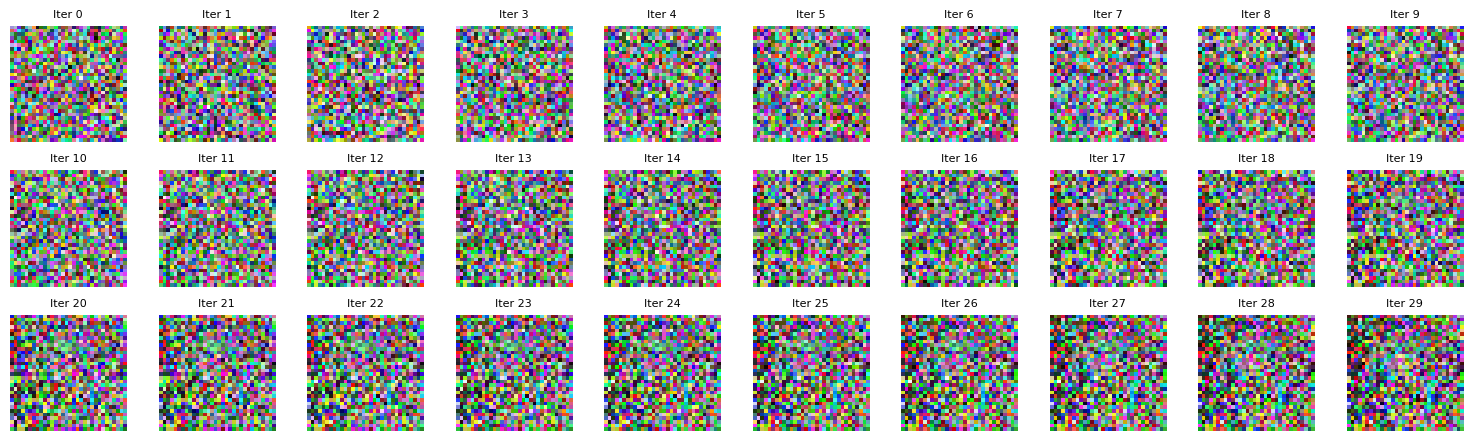

In [56]:
import matplotlib.pyplot as plt

# 假设 history 是一个包含图像的列表
num_images = len(history)
cols = 10  # 每行显示的图像数量
rows = (num_images + cols - 1) // cols  # 计算需要的行数

plt.figure(figsize=(15, rows * 1.5))
for i, img in enumerate(history):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)  # 显示图像
    plt.axis('off')  # 关闭坐标轴显示
    plt.title(f"Iter {i}", fontsize=8)  # 显示标题（迭代次数）
plt.tight_layout()
plt.show()


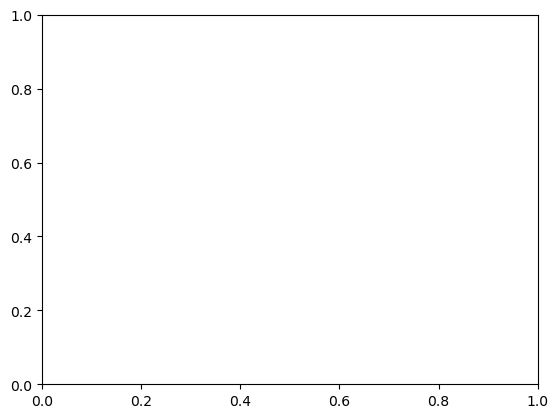

In [57]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.imshow(history[frame])
    ax.set_title(f"Iter {frame}")
    ax.axis('off')

ani = FuncAnimation(fig, update, frames=len(history), interval=200)  # 每帧间隔200ms
plt.show()


In [58]:
len(history)

30